# Deep Learning with Lasagne: The Force Awakens 
![alt text](../images/boardgame.jpg)

![alt text](../images/deeplearning.jpg "dl")

#  Let's classify the type of ship that appears in the image!

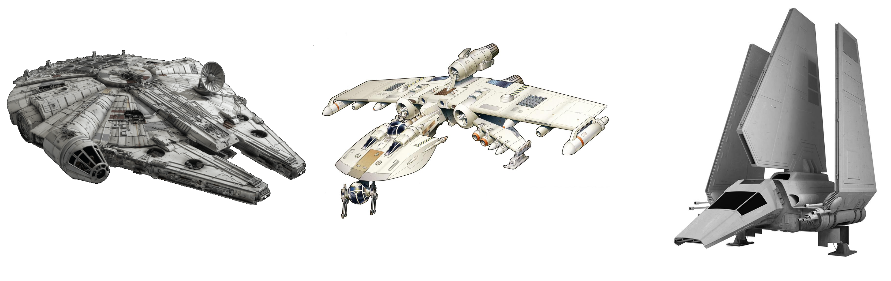

In [1]:
from IPython.display import Image
Image(filename='../images/ships.png') 

## How does our input data looks like?
![alt text](../images/dataset.png)

## Loading our images to a Pandas Dataframe

In [10]:
import os
import pandas as pd
import cv2

In [3]:
def images_to_file(path_to_photos):
    """
    Load images from folder and create a csv file with 
    X = pixel array and y = type of ship
    """
    ids = [os.path.splitext(image_id)[0] for image_id in os.listdir(path_to_photos)]
    df_out = pd.DataFrame(columns=['Image', 'Model', 'Model_enc'], index=ids)
    for image_file in os.listdir(path_to_photos):
            image = cv2.imread(os.path.join(path_to_photos, image_file), 0)
            df_out['Image'][os.path.splitext(image_file)[0]] = ' '.join(map(str, image.flatten()))
            df_out['Model'][os.path.splitext(image_file)[0]] = image_file.split('_')[0]
       
    catenc = pd.factorize(df_out['Model'])
    df_out['Model_enc'] = catenc[0]
    print(catenc)
    df_out.to_csv('../star_wars_data.csv')
    
    return df_out

### Now to format the input data for our network ...

In [11]:
import numpy as np
from sklearn.utils import shuffle

In [5]:
def load(images_dir="../data/all/", star_wars_fn='../star_wars_data.csv'):
    """
    Load images and target class for Falcon,
    Lambda and K-wing ships.
    """
    
    if os.path.exists(star_wars_fn):
        df = pd.read_csv(star_wars_fn)
    else:
        df = images_to_file(images_dir)
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    X = np.vstack(df['Image'].values) / 255.
    X = X.astype(np.float32)

    y = df['Model_enc'].values
    X, y = shuffle(X, y, random_state=42)
    y = y.astype(np.int32)
    
    return X, y

### What do we need to build our net ?

In [6]:
import warnings; warnings.simplefilter('ignore')
import theano
import lasagne
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from lasagne.layers import InputLayer, Conv2DLayer, DropoutLayer,\
                           MaxPool2DLayer, DenseLayer
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import BatchIterator

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: Unable to get the number of gpus available: CUDA driver version is insufficient for CUDA runtime version)


### How can we define the architecture of our network?

In [7]:
layers_1 = [
    # layer dealing with the input data
    (InputLayer, {'shape': (None, 1, 128, 128)}),
    
    # first stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 8, 'filter_size': 3,
     'W': lasagne.init.GlorotUniform()}),
    (MaxPool2DLayer, {'pool_size': 2}),

    # second stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 8, 'filter_size': 3,
     'W': lasagne.init.GlorotUniform()}),
    (MaxPool2DLayer, {'pool_size': 2}),
    
    # third stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 8, 'filter_size': 3,
     'W': lasagne.init.GlorotUniform()}),
    (MaxPool2DLayer, {'pool_size': 2}),
    
    # fourth stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 16, 'filter_size': 3,
     'W': lasagne.init.GlorotUniform()}),
    (MaxPool2DLayer, {'pool_size': 2}),
    
    # two dense layers with dropout
    (DenseLayer, {'num_units': 64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 64}),
    
    # the output layer
    (DenseLayer, {'num_units': 3, 
     'nonlinearity': lasagne.nonlinearities.softmax}),
]

In [8]:
def create_net(max_epochs=100):
    return NeuralNet(
        layers=layers_1,
        update=nesterov_momentum,
        update_learning_rate=theano.shared(np.float32(0.01)),
        #update_momentum=theano.shared(np.float32(0.9)),
        regression=False,
        #objective_loss_function=categorical_crossentropy,
        #batch_iterator_train=RotationBatchIterator(batch_size=512),
        #on_epoch_finished=[
        #    AdjustVariable('update_learning_rate', start=0.01, stop=0.001),
        #    AdjustVariable('update_momentum', start=0.9, stop=0.9999)
        #],
        max_epochs=max_epochs,
        verbose=1)

### Some Hyperparameter Tuning

Some things that you want to tune:
 - Net structure
 - learning rate
 - W initialization
 - Regularization
 

![alt text](../images/split.png "http://onlinelibrary.wiley.com/doi/10.15252/msb.20156651/full")
Image from [Deep learning for computational biology](http://onlinelibrary.wiley.com/doi/10.15252/msb.20156651/full)

[Practical Recommendations for Gradient-Based Training of Deep Architectures - Yoshua Bengio](https://arxiv.org/pdf/1206.5533v2.pdf)

In [9]:
from sklearn.cross_validation import train_test_split

def make_and_train_net_from_ship_data():
    images_to_file("../data/all/")
    x, y = load("../data/all")
    x = x.reshape(-1, 1, 128, 128)
    X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                        test_size=0.3,
                                                        random_state=42)
    print(X_train.shape)

    net = create_net(20)
    net.fit(X_train, y_train)
    return net, X_test, y_test

### Do I have to train my network every time I want to use it ??
![alt text](../images/pickle.jpg)

In [5]:
import sys
import pickle
sys.setrecursionlimit(1000000)

In [6]:
import os.path

PICKLE_FILE = '../data/ship_classifier.pickle'
net = None

if os.path.isfile(PICKLE_FILE):
    # We have run this notebook before and have a pickled net stored!
    print("Yay, pickle found!")
    with open(PICKLE_FILE, 'rb') as f:
        net = pickle.load(f)
else:
    # We don't have a net yet, so make one then pickle it for the future.
    net, X_test, y_test = make_and_train_net_from_ship_data()
    
    with open(PICKLE_FILE, 'wb') as f:
        pickle.dump(net, f, -1)

Yay, pickle found!


WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [7]:
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()

net.verbose = 1
net.initialize()
layer_info(net)

# Neural Network with 43699 learnable parameters

## Layer information

  #  name        size
---  ----------  ---------
  0  input0      1x128x128
  1  conv2d1     8x126x126
  2  maxpool2d2  8x63x63
  3  conv2d3     8x61x61
  4  maxpool2d4  8x30x30
  5  conv2d5     8x28x28
  6  maxpool2d6  8x14x14
  7  conv2d7     16x12x12
  8  maxpool2d8  16x6x6
  9  dense9      64
 10  dropout10   64
 11  dense11     64
 12  dense12     3



## How can we test our net?

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nolearn.lasagne import visualize

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: Unable to get the number of gpus available: CUDA driver version is insufficient for CUDA runtime version)


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### Taking a look at our *learning rate*


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.4/dist-packages/matplotlib/pyplot.py'>

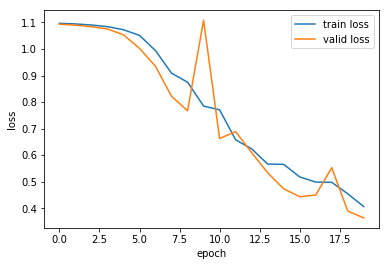

In [8]:
%matplotlib inline
visualize.plot_loss(net)

### How did our trained network do while classifying new ships?

In [16]:
def plot_matrix(clf, X_test, y_test):
    """
    Plot Confusion Matrix from a given classifier
    """
   
    plt.clf()
    
    cm = confusion_matrix(y_test, clf.predict(X_test))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    print(cm_normalized)
    plt.tick_params(labelsize=20)

    ax = plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    cb = plt.colorbar()
    cb.ax.tick_params(axis='both', labelsize=20)
    plt.ylabel("True label", fontsize=20)
    plt.xlabel("Predicted label", fontsize=20)
    plt.xticks(range(3),range(3))
    plt.yticks(range(3),range(3))



### What happens inside the network?

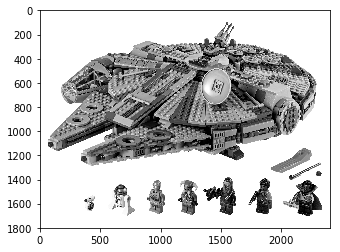

In [14]:
%matplotlib inline

my_image = cv2.imread("../data/lego-star-wars-ship.jpg", 0)
plt.imshow(my_image, cmap='gray')
res = cv2.resize(my_image, (128, 128),
                         interpolation=cv2.INTER_CUBIC)
X = format_net(res)

In [15]:
net.predict(X)

array([1])

### How sure is my network that I identify?

In [16]:
proba = net.predict_proba(X)
proba, proba.sum()

(array([[ 0.07154261,  0.91448343,  0.01397396]], dtype=float32), 1.0)

In [17]:
proba[0, np.argmax(proba)]

0.91448343

#### What happens if we cover parts of our image? Which parts are important for classification?

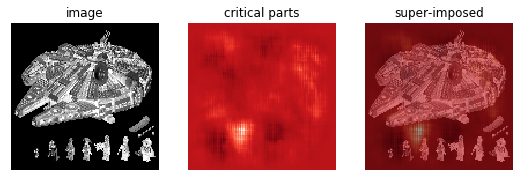

In [18]:
h = visualize.plot_occlusion(net, X, [2])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.4/dist-packages/matplotlib/pyplot.py'>

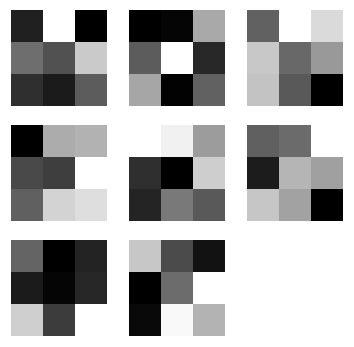

In [22]:
visualize.plot_conv_weights(net.layers_[1])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.4/dist-packages/matplotlib/pyplot.py'>

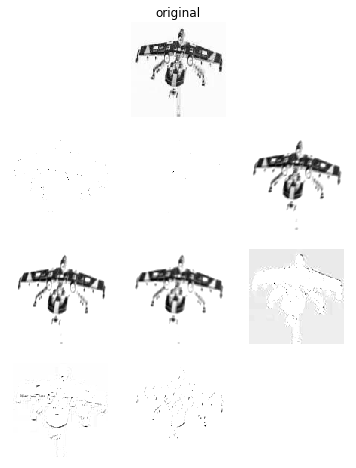

In [23]:
visualize.plot_conv_activity(net.layers_['conv2d1'], X)

### Now let's connect our notebook to Anvil!

In [13]:
import anvil.media
import cv2
import numpy as np

tipos_naves = {0: 'K-Wing', 1: 'Falcon', 2: 'Lambda'}

def format_net(my_image):
        X = np.vstack(my_image) / 255.
        X = X.astype(np.float32)
        X = X.reshape(-1, 1, 128, 128)
        
        return X

@anvil.server.callable
def what_kind_of_ship_is_it(file):
    print("Starting to classify...")
    with anvil.media.TempFile(file) as filename:
        # load as grayscale
        my_image = cv2.imread(filename, 0)
        
    # frame = cv2.cvtColor(my_image, cv2.COLOR_RGB2GRAY)
    frame = cv2.equalizeHist(my_image)
    res = cv2.resize(frame, (128, 128),
                         interpolation=cv2.INTER_CUBIC)
    X = format_net(res)
    X = X.astype(np.float32)
    
    # This will just be a number, need to turn into text again (0, 1, 2 = kwing, falcon, lambda)
    predicted_category = net.predict(X)
    predicted_ship = tipos_naves[predicted_category[0]]
    
    proba = net.predict_proba(X)
    probability = proba[0, np.argmax(proba)]
    
    return (predicted_ship, probability)
    

In [3]:
import anvil.server

with open("../keyfile.txt", 'r') as fin:
    uplink_key = fin.readline()
        
anvil.server.connect(uplink_key)  # our Ship Classifer app

anvil.server.wait_forever()  # So executed notebook will not close

['TNWFYMEADSUY33L26SKQAACB-FNICZ2KNQWPL5HXD']
Connecting to wss://anvil.works/uplink
Anvil websocket open
Anvil websocket closed (code 1000, reason=b'')


AnvilWrappedError: 'Connection to Anvil Uplink server lost'

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Anvil websocket closed (code 1000, reason=b'')
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Anvil websocket closed (code 1000, reason=b'')
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Anvil websocket closed (code 1000, reason=b'')
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Anvil websocket closed (code 1000, reason=b'')
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Anvil websocket closed (code 1000, reason=b'')
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Anvil websocket closed (code 1000, reason=b'')
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Anvil websocket closed (code 1000, reason=b'')


### I want to go deeper!
![alt text](../images/inception-meme.png)

- [Neural Networks and Deep Learning free online book](http://neuralnetworksanddeeplearning.com/index.html)
- [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/)
- [Unsupervised Feature Learning and Deep Learning.](http://deeplearning.stanford.edu/tutorial/)
- [Practical Recommendations for Gradient-Based Training of Deep Architectures - Yoshua Bengio](https://arxiv.org/pdf/1206.5533v2.pdf)
- [Efficient BackProp](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)
- Daniel Nouri. 2014. nolearn: scikit-learn compatible neural network library https://github.com/dnouri/nolearn
- LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. Nature, 521(7553), 436–444. 
- Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research, 15, 1929–1958.
- Bergstra, J., Bastien, F., Breuleux, O., Lamblin, P., Pascanu, R., Delalleau, O., Bengio, Y. (2011). Theano: Deep Learning on GPUs with Python. Journal of Machine Learning Research, 1, 1–48.
- Shwartz-Ziv, R., & Tishby, N. (2017). Opening the Black Box of Deep Neural Networks via Information. arXiv, 1–19. 
![alt text](../images/bye.jpg)

